# Pruning the fully connected layers of a CNN


In [1]:
import tensorflow as tf
import numpy as np
from parana.Model import Model
from parana.Layers import fc_layer
from parana.Layers import softmax_layer
from parana.optimizer import optimizer
from parana.optimizer import adamopt
from parana.Layers import conv_layer
from parana.parameter_saver import saver
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True, reshape=False)
from IPython.display import clear_output
import pickle
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
from parana.parameter_pruning import lobotomizer
from parana.layer_wiggles import get_mean_activations
from parana.wiggles import get_absolute_values
from parana.parameter_selection import get_k_smallest

path = 'path'

noise = tf.Variable(tf.zeros([28,28,1]), name='x_noise')
set_zero_noise = tf.assign(noise, tf.zeros([28,28,1]))
noise_placeholder = tf.placeholder('float', [28, 28,1], name = 'noise_placeholder')
assign_noise = tf.clip_by_value(tf.assign(noise, noise_placeholder), 0, 1)

class this_model(Model):
    
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
        self.cost_function = 'quadratic_l2'
        self.logit_cost_function = 'quadratic_l2'
        self.dropout = 0
        self.layers = [conv_layer(inputs = inputs + noise,
                                 height = 7, 
                                 width = 7, 
                                 filters = 12, 
                                 padding = 4, 
                                 stride = 1,
                                 flatten = False,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001)]
        self.layers.append(conv_layer(inputs = self.layers[0].activate,
                                 height = 5, 
                                 width = 5, 
                                 filters = 15, 
                                 padding = 2, 
                                 stride = 1,
                                 flatten = False,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(conv_layer(inputs = self.layers[1].activate,
                                 height = 3, 
                                 width = 3, 
                                 filters = 25, 
                                 padding = 1, 
                                 stride = 1,
                                 flatten = False,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(conv_layer(inputs = self.layers[2].activate,
                                 height = 3, 
                                 width = 3, 
                                 filters = 20, 
                                 padding = 1, 
                                 stride = 1,
                                 flatten = True,
                                 weight_init = 'xavier',
                                 weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(fc_layer(inputs = self.layers[3].activate,
                                   size = 1500,
                                   weight_init = 'xavier',
                                   weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(fc_layer(inputs=self.layers[4].activate, 
                               weight_init = 'xavier',
                               size=500, 
                               weight_decay=0.0001, bias_decay=0.0001))
        self.layers.append(softmax_layer(inputs=self.layers[5].activate, 
                                          size=10, 
                                          weight_decay=0.0001, bias_decay=0.0001))

X = tf.placeholder('float', [None, 28, 28, 1], name = 'Inputs')
y = tf.placeholder('float', [None, 10], name = 'Labels')   

sess = tf.Session()

mymodel = this_model(X, y)

model_saver = saver(mymodel, sess)

sess.run(tf.global_variables_initializer())

C:\Users\Jim\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Populating the interactive namespace from numpy and matplotlib


In [2]:
path = 'path'
model_saver.load_parameters('{}cnn99.34%.p'.format(path))
print(model_saver.split_accuracy(session = sess,
                       stages=20,
                       inputs = mnist.test.images, 
                       labels = mnist.test.labels))

Parameters loaded from  c:/users/jim/tensorflowtrials/cnn99.34%.p
0.9934869766235351


# Helper functions
Test_function gets arrays of results with incrementally increasing pruning ratios
absvalues prunes based on absolute values, and activationvalues prunes based on mean activation values.

In [3]:
model_saver.restore_parameters()
import pickle
path = 'path'

file_list = ['{}adv_class_3_limit_0.25.p', '{}adv_class_2_limit_0.25.p',
             '{}adv_class_1_limit_0.35.p', '{}adv_class_5_limit_0.25.p',
             '{}adv_class_5_limit_0.35.p', '{}adv_class_4_limit_0.25.p',
             '{}adv_class_7_limit_0.3.p', '{}adv_class_9_limit_0.3.p']


def test_function(prune_step, layers_list, start_ratio, step_size, steps, file_list):
    accuracies = [[] for i in range(len(file_list)+1)]
    prune_ratio = start_ratio
    prune_ratios = []
    #Get accuracies without noise first
    for i in range(steps):
        prune_ratios.append(prune_ratio)
        this_accuracy = model_saver.split_accuracy(session = sess,
                       stages=20,
                       inputs = mnist.test.images, 
                       labels = mnist.test.labels)
        accuracies[0].append(this_accuracy)
        for i in enumerate(file_list):
            noisevector = pickle.load(open(i[1].format(path), 'rb'))
            noisevector = np.reshape(noisevector, (28,28,1))
            sess.run(assign_noise, {noise_placeholder: noisevector})
            accuracies[i[0]+1].append(model_saver.split_accuracy(session = sess,
                       stages=20,
                       inputs = mnist.test.images, 
                       labels = mnist.test.labels))
        prune_step(prune_ratio,
                   layers_list)
        prune_ratio = prune_ratio + step_size
        sess.run(set_zero_noise)
    model_saver.restore_parameters()
    return accuracies, prune_ratios

In [4]:
absvalues = lobotomizer(session = sess,
                          model = mymodel,
                          parameters_list = mymodel.get_weights[4:],
                          wigglyness = get_absolute_values,
                          parameter_selection = get_k_smallest,
                          cost = mymodel.cost,
                          data_function = mnist.train.next_batch,
                          X = X, y = y)

In [5]:
path = 'path'
activationvalues = lobotomizer(session = sess,
                               model = mymodel,
                               parameters_list = mymodel.get_weights[4:],
                               layers_list = mymodel.layers[4:],
                               wigglyness = get_mean_activations,
                               parameter_selection = get_k_smallest,
                               cost = mymodel.cost,
                               data_function = mnist.train.next_batch,
                               X = X, y = y)
activationvalues.get_wigglyness(iterations = 2000)
print('gotit')

gotit


# Make some plots

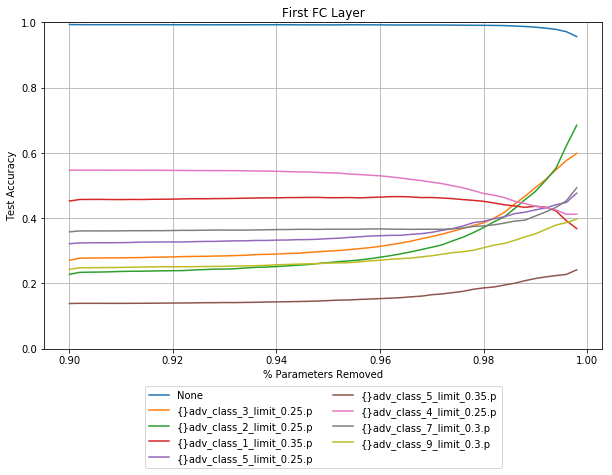

In [7]:
model_saver.restore_parameters()
act_accuracy_bigstep, prune_ratios = test_function(activationvalues.prune_step, layers_list = [mymodel.layers[4]],
                                                  start_ratio = 0.9, step_size = 0.002, steps = 50, file_list = file_list)

label_list = ['None','{}adv_class_3_limit_0.25.p', '{}adv_class_2_limit_0.25.p',
             '{}adv_class_1_limit_0.35.p', '{}adv_class_5_limit_0.25.p',
             '{}adv_class_5_limit_0.35.p', '{}adv_class_4_limit_0.25.p',
             '{}adv_class_7_limit_0.3.p', '{}adv_class_9_limit_0.3.p']

for i in range(len(act_accuracy_bigstep)):
    plt.plot(prune_ratios, act_accuracy_bigstep[i], label = label_list[i])
plt.legend()
plt.grid()
plt.title('First FC Layer')
plt.xlabel('% Parameters Removed')
plt.ylabel('Test Accuracy')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.ylim(0,1)
plt.show()

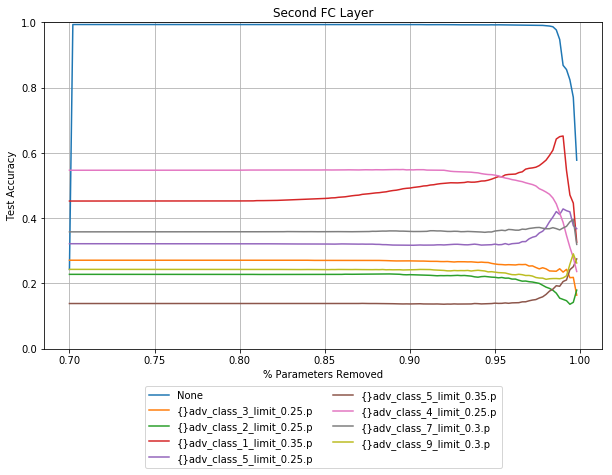

In [10]:
model_saver.restore_parameters()
#activationvalues.prune_step(0.985, layers_list = [mymodel.layers[4]])
act_accuracy_layer5, prune_ratios = test_function(activationvalues.prune_step, layers_list = [mymodel.layers[5]],
                                                   start_ratio = 0.7, step_size = 0.002, steps = 150, file_list = file_list)

label_list = ['None','{}adv_class_3_limit_0.25.p', '{}adv_class_2_limit_0.25.p',
             '{}adv_class_1_limit_0.35.p', '{}adv_class_5_limit_0.25.p',
             '{}adv_class_5_limit_0.35.p', '{}adv_class_4_limit_0.25.p',
             '{}adv_class_7_limit_0.3.p', '{}adv_class_9_limit_0.3.p']

for i in range(len(act_accuracy_bigstep)):
    plt.plot(prune_ratios, act_accuracy_layer5[i], label = label_list[i])
plt.legend()
plt.grid()
plt.title('Second FC Layer')
plt.xlabel('% Parameters Removed')
plt.ylabel('Test Accuracy')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.ylim(0,1)
plt.show()

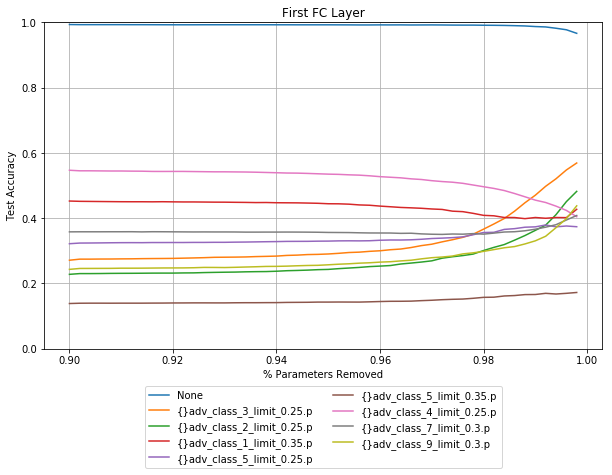

In [11]:
model_saver.restore_parameters()
abs_accuracy_bigstep, prune_ratios = test_function(absvalues.prune_step, layers_list = [mymodel.layers[4]],
                                                  start_ratio = 0.9, step_size = 0.002, steps = 50, file_list = file_list)

label_list = ['None','{}adv_class_3_limit_0.25.p', '{}adv_class_2_limit_0.25.p',
             '{}adv_class_1_limit_0.35.p', '{}adv_class_5_limit_0.25.p',
             '{}adv_class_5_limit_0.35.p', '{}adv_class_4_limit_0.25.p',
             '{}adv_class_7_limit_0.3.p', '{}adv_class_9_limit_0.3.p']

for i in range(len(abs_accuracy_bigstep)):
    plt.plot(prune_ratios, abs_accuracy_bigstep[i], label = label_list[i])
plt.legend()
plt.grid()
plt.title('First FC Layer')
plt.xlabel('% Parameters Removed')
plt.ylabel('Test Accuracy')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.ylim(0,1)
plt.show()

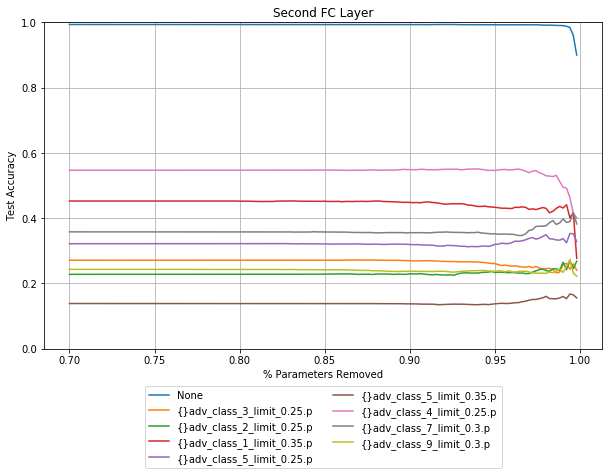

In [12]:
model_saver.restore_parameters()
abs_accuracy_bigstep, prune_ratios = test_function(absvalues.prune_step, layers_list = [mymodel.layers[5]],
                                                  start_ratio = 0.7, step_size = 0.002, steps = 150, file_list = file_list)

label_list = ['None','{}adv_class_3_limit_0.25.p', '{}adv_class_2_limit_0.25.p',
             '{}adv_class_1_limit_0.35.p', '{}adv_class_5_limit_0.25.p',
             '{}adv_class_5_limit_0.35.p', '{}adv_class_4_limit_0.25.p',
             '{}adv_class_7_limit_0.3.p', '{}adv_class_9_limit_0.3.p']

for i in range(len(abs_accuracy_bigstep)):
    plt.plot(prune_ratios, abs_accuracy_bigstep[i], label = label_list[i])
plt.legend()
plt.grid()
plt.title('Second FC Layer')
plt.xlabel('% Parameters Removed')
plt.ylabel('Test Accuracy')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.ylim(0,1)
plt.show()

In [39]:
model_saver.restore_parameters()
activationvalues.prune_step(0.99, layers_list = [mymodel.layers[4]])
print(model_saver.split_accuracy(session = sess,
                   stages=20,
                   inputs = mnist.test.images, 
                   labels = mnist.test.labels))

0.9845691412687302


# Best results
Set the pruning ratios for both layers to try and get the best results with a selection of noise vectors

In [17]:
model_saver.restore_parameters()
activationvalues.prune_step(0.99, layers_list = [mymodel.layers[4]])
activationvalues.prune_step(0.96, layers_list = [mymodel.layers[5]])
absvalues.prune_step(0.992, layers_list = [mymodel.layers[4]])

import pickle
path = 'path'

file_list = ['{}adv_class_3_limit_0.25.p', '{}adv_class_2_limit_0.25.p',
             '{}adv_class_1_limit_0.35.p', '{}adv_class_5_limit_0.25.p',
             '{}adv_class_5_limit_0.35.p', '{}adv_class_4_limit_0.25.p',
             '{}adv_class_7_limit_0.3.p', '{}adv_class_9_limit_0.3.p']

print(model_saver.split_accuracy(session = sess,
                       stages=20,
                       inputs = mnist.test.images, 
                       labels = mnist.test.labels))
for i in file_list:
    noisevector = np.reshape(pickle.load(open(i.format(path), 'rb')), (28,28,1))
    sess.run(assign_noise, {noise_placeholder: noisevector})
    print(model_saver.split_accuracy(session = sess,
                       stages=20,
                       inputs = mnist.test.images, 
                       labels = mnist.test.labels))

sess.run(set_zero_noise) 
print('Done')

0.9795591235160828
0.5
0.46382765620946886
0.4884769544005394
0.4055110216140747
0.2202404797077179
0.3927855670452118
0.4377755537629128
0.35791583061218263
Done
